# Odkrywanie Wiedzy i Systemy Rekomendacyjne
### *Laboratorium 4*
## **Tworzenie i ocena listy Top-N rekomendacji**

Instalacja najnowszej stabilnej wersji biblioteki LensKit.

In [14]:
# %pip install --upgrade pip
# %pip install lenskit
%pip install scikit-learn
# %pip install pandas
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import potrzebnych elementów z biblioteki LensKit

In [15]:
from lenskit.als import BiasedMFScorer
from lenskit.sklearn.svd import BiasedSVDScorer
from lenskit.batch import recommend
from lenskit.data import ItemListCollection, UserIDKey, load_movielens
from lenskit.knn import ItemKNNScorer, UserKNNScorer
from lenskit.metrics import Precision, Recall, NDCG, RecipRank, RunAnalysis
from lenskit.pipeline import topn_pipeline
from lenskit.splitting import SampleFrac, crossfold_users

Import innych użytecznych bibliotek

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

Montowanie dysku Google Drive. Ten etap można pominąć i wrzucić dane bezpośrednio do danych środowiska w Google Colab, albo w odpowiedniej lokalizacji na dysku w przypadku uruchamiania kodu lokalnie.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Wczytanie znanych z poprzednich zajęć danych - MovieLens.

**UWAGA!** Zmodyfikuj odpowiedni ścieżkę do danych.

In [17]:
mlds = load_movielens('/Users/adam/Desktop/PG_OWISR/lab4/ml-latest-small')
mlds.interaction_table(format="pandas", original_ids=True).head()

,user_id,item_id,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


### **Przykład 1.**
W następującym przykładzie ocenimy działanie metody rozkładu macierzy (MF) z wykorzystaniem walidacji skrośnej i miary MRR (Mean Reciprocal Rank).

Na początku inicjalizujemy model, ustawiając ilość cech ukrytych na 50.

In [18]:
model_als = BiasedMFScorer(features=50)

W LensKit wykorzystuje się obiek typu Pipeline do przeprowadzenia rekomendacji. W związku z tym musimy zaimplementować po jednym obiekcie dla modelu.

In [19]:
pipe_als = topn_pipeline(model_als)

Poniższy kod został omówiony w komentarzach.

In [ ]:
# Zbiór danych testowych będzie zorganizowany po użytkowniku (chcemy testować poprawność rekomendacji dla kazdego użytkownika)
all_test = ItemListCollection(UserIDKey)
# Rekomendacje będą generowane dla każdej pary model-użytkownik
all_recs = ItemListCollection(["model", "user_id"])

# Wykonujemy 5-krotną walidację skrośną
for split in crossfold_users(mlds, 5, SampleFrac(0.2)):
    # zapisujemy dane testowe
    all_test.add_from(split.test)

    # Klonujemy i trenujemy pipeline dla każdego splitu dla rozkładu macierzy
    fit_als = pipe_als.clone()
    fit_als.train(split.train)
    # Generujemy i zapisujemy 10 rekomendacji
    als_recs = recommend(fit_als, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="ALS")

100%|██████████| 15/15 [00:01<00:00, 12.01it/s]


[1.071913]
[1.071913]


W celu ewaluacji algorytmu miarą MRR skorzystamy z obiektu klasy RunAnalysis i miary RecipRank z LensKit.

In [21]:
ran = RunAnalysis()
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)


Uśredniamy wynik dla modelu MF.

In [22]:
results.list_metrics().groupby("model").mean()

,RecipRank
model,
ALS,0.145331


Wizualizujemy wynik na wykresie

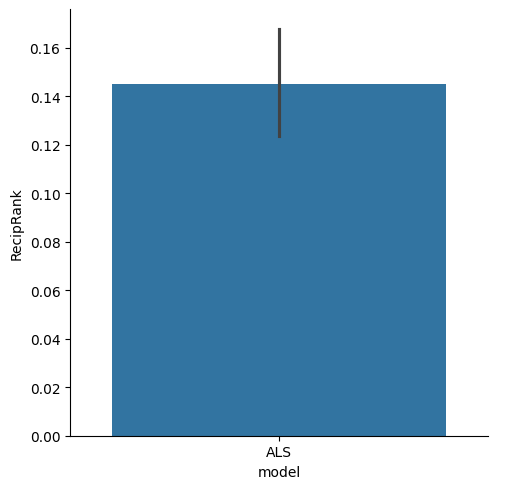

In [23]:
sns.catplot(results.list_metrics().reset_index(), x="model", y="RecipRank", kind="bar")
plt.show()

## Zadanie 1. (2 pkt)
1. Zmodyfikuj powyższy przykład tak, aby porównać omawiany algorytm typu MF z algorytmem UserKNN.
2. Co możesz powiedzieć o wygenerowanych listach przez oba algorytmy na podstawie wartości miary MRR?

         RecipRank
model             
ALS       0.124035
UserKNN   0.003543


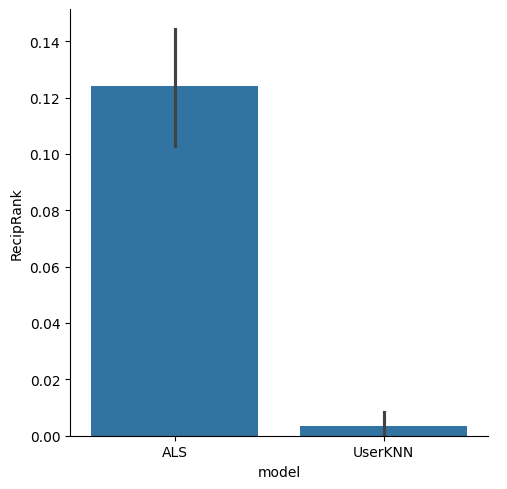

In [26]:
model_als = BiasedMFScorer(features=50)
pipe_als = topn_pipeline(model_als)

model_userknn = UserKNNScorer()
pipe_userknn = topn_pipeline(model_userknn)

# Zbiór danych testowych będzie zorganizowany po użytkowniku (chcemy testować poprawność rekomendacji dla kazdego użytkownika)
all_test = ItemListCollection(UserIDKey)
# Rekomendacje będą generowane dla każdej pary model-użytkownik
all_recs = ItemListCollection(["model", "user_id"])

# Wykonujemy 5-krotną walidację skrośną
for split in crossfold_users(mlds, 5, SampleFrac(0.2)):
    # zapisujemy dane testowe
    all_test.add_from(split.test)

    # Klonujemy i trenujemy pipeline dla każdego splitu dla rozkładu macierzy
    fit_als = pipe_als.clone()
    fit_als.train(split.train)

    fit_userknn = pipe_userknn.clone()
    fit_userknn.train(split.train)

    # Generujemy i zapisujemy 10 rekomendacji
    als_recs = recommend(fit_als, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="ALS")

    userknn_recs = recommend(fit_userknn, split.test.keys(), 10)
    all_recs.add_from(userknn_recs, model="UserKNN")

ran = RunAnalysis()
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)
# results.list_metrics().groupby("model").mean()
print(results.list_metrics().groupby("model").mean())

sns.catplot(results.list_metrics().reset_index(), x="model", y="RecipRank", kind="bar")
plt.show()

> Miejsce na odpowiedź nr 2.
---

## Zadanie 2. (2 pkt)

1.  Rozszerz powyższe zadanie o dodatkową miarę - NDCG.
2.  Co teraz możesz powiedzieć o porównywanych algorytmach? Czy połączenie miar MRR i NDCG pozwala na lepsze zrozumienie wyników oceny?



         RecipRank      NDCG
model                       
ALS       0.128484  0.028038
UserKNN   0.004098  0.000482
  model  user_id  RecipRank      NDCG
0   ALS      601        1.0  0.335171
1   ALS       73        0.0  0.000000
2   ALS       10        0.0  0.000000
3   ALS      230        0.0  0.000000
4   ALS      419        0.0  0.000000
Index(['model', 'user_id', 'RecipRank', 'NDCG'], dtype='object')
  model     Metric  Score
0   ALS  RecipRank    1.0
1   ALS  RecipRank    0.0
2   ALS  RecipRank    0.0
3   ALS  RecipRank    0.0
4   ALS  RecipRank    0.0
Index(['model', 'Metric', 'Score'], dtype='object')


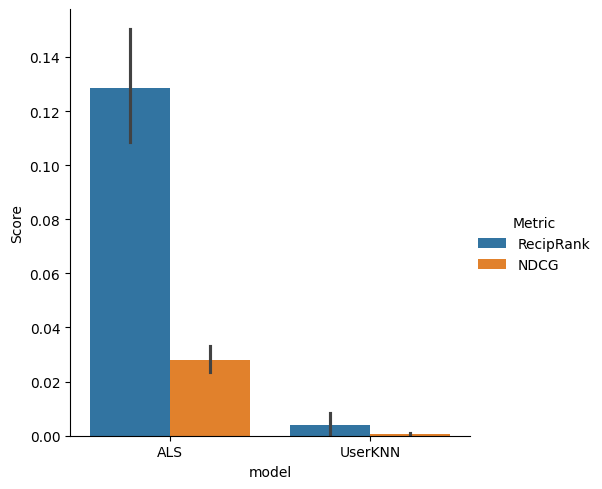

In [62]:
model_als = BiasedMFScorer(features=50)
pipe_als = topn_pipeline(model_als)

model_userknn = UserKNNScorer()
pipe_userknn = topn_pipeline(model_userknn)

# Zbiór danych testowych będzie zorganizowany po użytkowniku (chcemy testować poprawność rekomendacji dla kazdego użytkownika)
all_test = ItemListCollection(UserIDKey)
# Rekomendacje będą generowane dla każdej pary model-użytkownik
all_recs = ItemListCollection(["model", "user_id"])

# Wykonujemy 5-krotną walidację skrośną
for split in crossfold_users(mlds, 5, SampleFrac(0.2)):
    # zapisujemy dane testowe
    all_test.add_from(split.test)

    # Klonujemy i trenujemy pipeline dla każdego splitu dla rozkładu macierzy
    fit_als = pipe_als.clone()
    fit_als.train(split.train)

    fit_userknn = pipe_userknn.clone()
    fit_userknn.train(split.train)

    # Generujemy i zapisujemy 10 rekomendacji
    als_recs = recommend(fit_als, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="ALS")

    userknn_recs = recommend(fit_userknn, split.test.keys(), 10)
    all_recs.add_from(userknn_recs, model="UserKNN")

ran = RunAnalysis()
ran.add_metric(RecipRank())
ran.add_metric(NDCG())
results = ran.measure(all_recs, all_test)
# results.list_metrics().groupby("model").mean()
print(results.list_metrics().groupby("model").mean())
df = results.list_metrics().reset_index()
print(df.head())
print(df.columns)
df_melted = df.melt(id_vars="model", value_vars=["RecipRank", "NDCG"], 
                    var_name="Metric", value_name="Score")
print(df_melted.head())
print(df_melted.columns)
sns.catplot(data=df_melted, x="model", y="Score", hue="Metric", kind="bar")
plt.show()

> Miejsce na odpowiedź 2.
---

> # **SVD, ItemKNN, hold-out validation, precision i recall, zamiana na implicit feedback - porównanie ALS z BPR.**




###  **Przykład 2.**
Następujący przykład przedstawia ocenę algorytmu SVD z wykorzystaniem prostego podziału na zbiory treningowy i testowy w stosunku 3:1.

Implementacja funkcji do podziału zbioru danych.

In [29]:
from lenskit.data import Dataset
from lenskit.splitting import TTSplit, split_global_time

def split_fraction(data: Dataset, test_frac: float) -> TTSplit:
    logs = data.interaction_table(format="pandas")
    time = logs["timestamp"].quantile(1 - test_frac)
    split = split_global_time(data, time)
    return split

Podział danych.

In [ ]:
tt_split = split_fraction(mlds, 0.25)
train_data, test_data = tt_split.train, tt_split.test

TypeError: 'Dataset' object is not subscriptable

Utworzenie modelu i wygenerowanie 10 rekomendacji.

In [ ]:
model_svd = BiasedSVDScorer(factors=20)

pipe_svd = topn_pipeline(model_svd)
pipe_svd.train(train_data)
# Generujemy i zapisujemy 10 rekomendacji
recs = recommend(pipe_svd, test_data.keys(), 10)
print(recs[0][1][0].field('score'))
print(recs[0][1][1].field('score'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


TypeError: 'Dataset' object is not subscriptable

In [42]:
ra = RunAnalysis()
ra.add_metric(RecipRank())
ra.add_metric(NDCG())
tests = ItemListCollection(UserIDKey)
tests.add_from(test_data)
results = ra.measure(recs, tests)

In [43]:
results.list_metrics().mean()

RecipRank    0.670674
NDCG         0.061397
dtype: float64

## Zadanie 3. (2 pkt)

1.   Rozszerz ewaluację o miary precyzji i czułości. Zwizualizuj wyniki wszystkich 4 miar na wykresie.
2. Co możesz powiedzieć o otrzymanych wynikach?





RecipRank    0.670674
NDCG         0.061397
Precision    0.195775
Recall       0.025196
dtype: float64


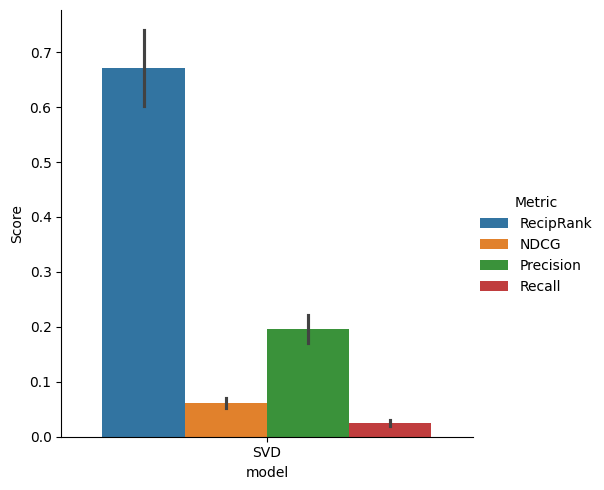

In [69]:
ra = RunAnalysis()
ra.add_metric(RecipRank())
ra.add_metric(NDCG())
ra.add_metric(Precision())
ra.add_metric(Recall())
tests = ItemListCollection(UserIDKey)
tests.add_from(test_data)
results = ra.measure(recs, tests)

print(results.list_metrics().mean())

df = results.list_metrics().reset_index()
df["model"] = "SVD"
df_melted = df.melt(id_vars="model", 
                    value_vars=["RecipRank", "NDCG", "Precision", "Recall"], 
                    var_name="Metric", 
                    value_name="Score")
sns.catplot(data=df_melted, x="model", y="Score", hue="Metric", kind="bar")

> Miejscje na odpowiedź 2.
---

## Zadanie 4. (2 pkt)
1.   Przetestuj inne wartości dla ilości cech ukrytych oraz liczby generowanych rekomendacji.
2.   Czy powyższe zmiany wypływają na wartości testowanych metryk? Co nam to mówi o algorytmie?



RecipRank    0.665853
NDCG         0.061536
Precision    0.196479
Recall       0.025305
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.672184
NDCG         0.089754
Precision    0.223592
Recall       0.055149
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.673550
NDCG         0.139629
Precision    0.207042
Recall       0.122485
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.663632
NDCG         0.060557
Precision    0.193662
Recall       0.024507
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.675900
NDCG         0.090077
Precision    0.223944
Recall       0.055348
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.674051
NDCG         0.139381
Precision    0.206761
Recall       0.122576
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.665216
NDCG         0.060666
Precision    0.194366
Recall       0.024913
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.679445
NDCG         0.089676
Precision    0.223592
Recall       0.055101
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.675137
NDCG         0.139173
Precision    0.207324
Recall       0.122643
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.666225
NDCG         0.060697
Precision    0.194366
Recall       0.024558
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.672659
NDCG         0.089784
Precision    0.223592
Recall       0.055094
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/type_adapter.py:572: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `dict[literal['user','item'], float]` - serialized value may not be as expected [input_value=5, input_type=int])
  return self.serializer.to_python(


RecipRank    0.681698
NDCG         0.139407
Precision    0.206620
Recall       0.122443
dtype: float64


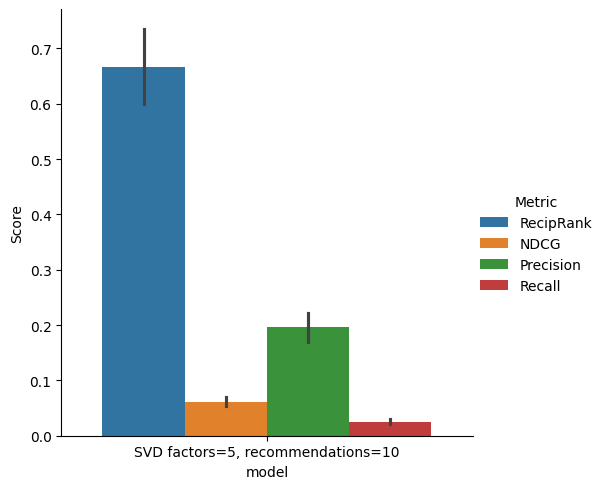

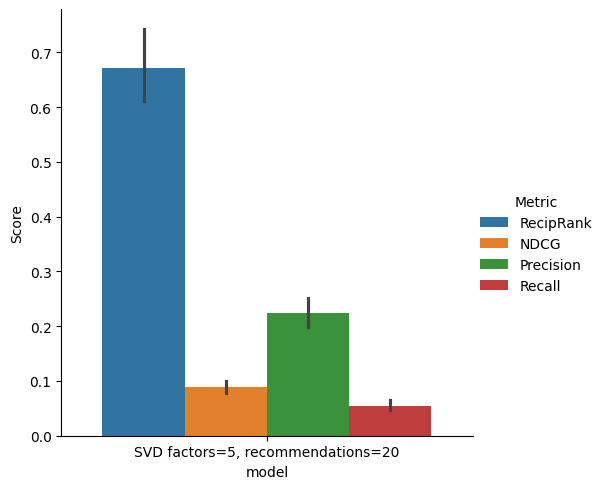

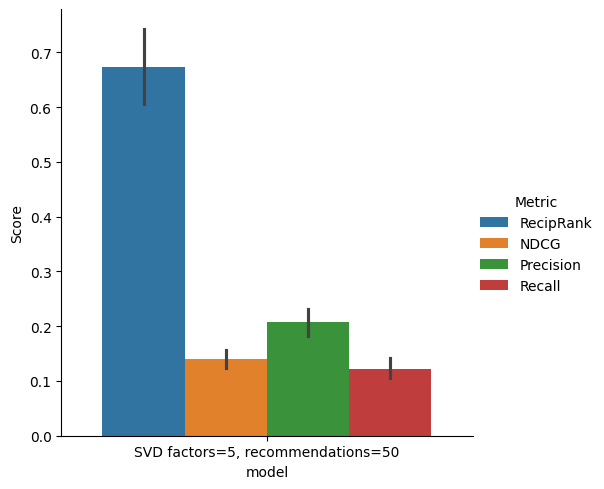

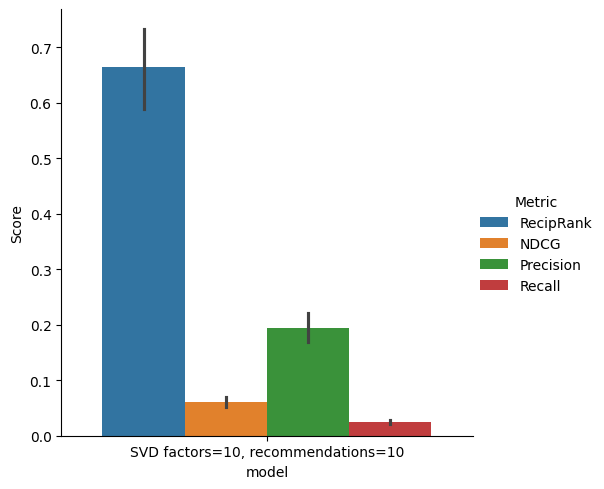

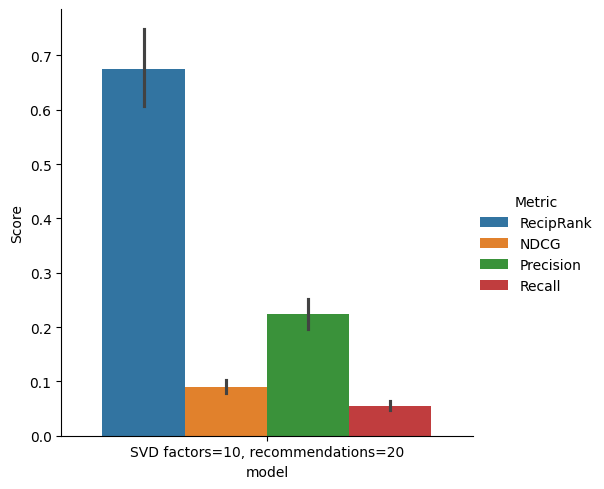

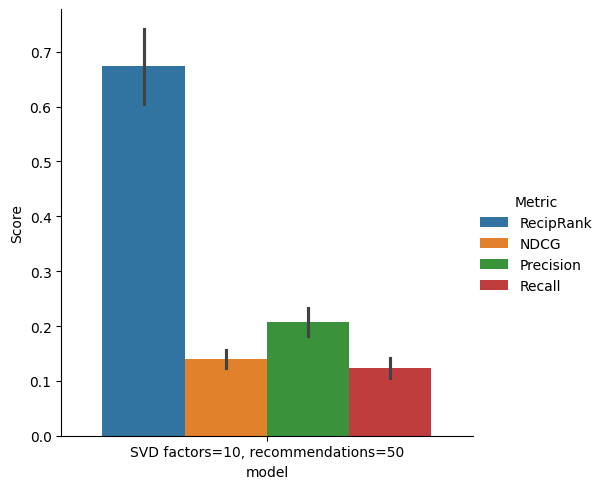

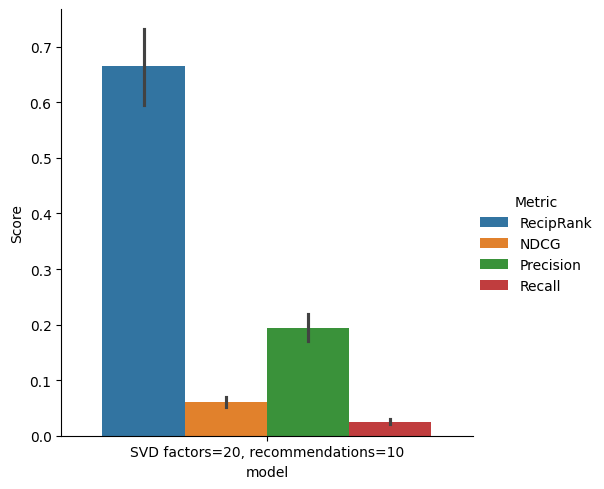

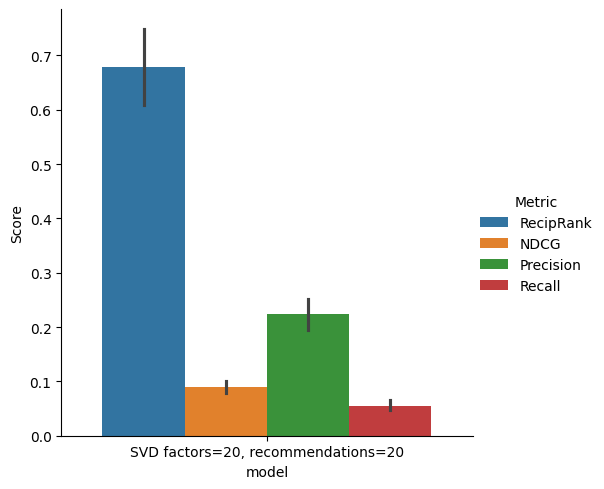

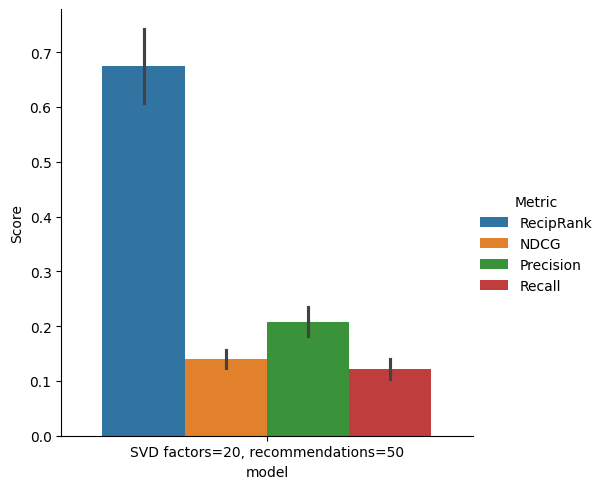

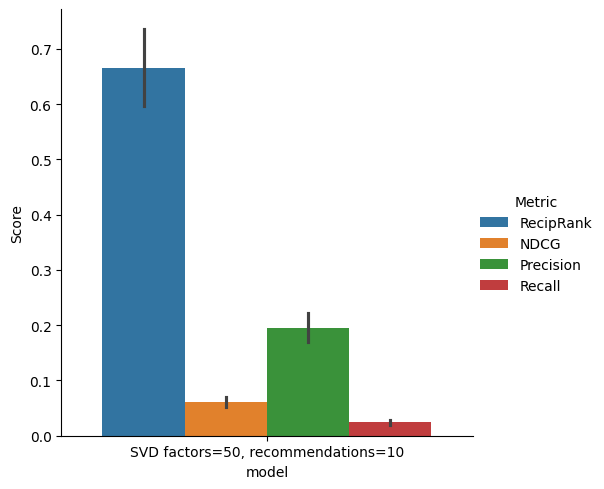

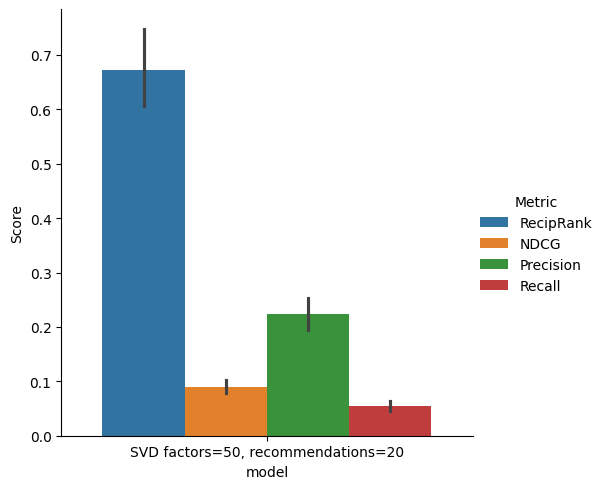

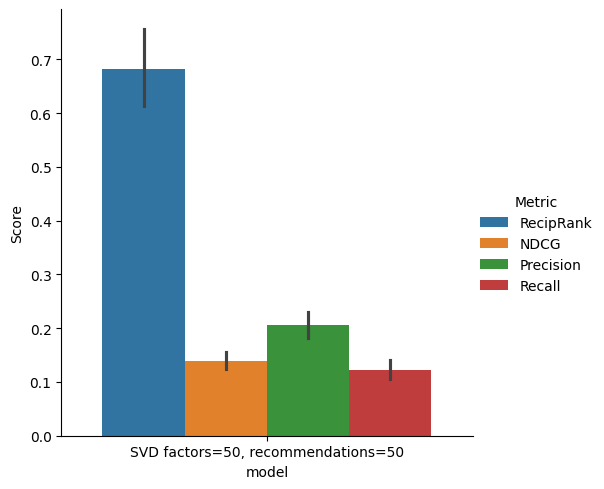

In [82]:
factors = [5, 10, 20, 50]
recommendations = [10, 20, 50]

for f in factors:
    for r in recommendations:
        model_svd = BiasedSVDScorer(factors=f)

        pipe_svd = topn_pipeline(model_svd)
        pipe_svd.train(train_data)
        # Generujemy i zapisujemy 10 rekomendacji
        recs = recommend(pipe_svd, test_data.keys(), r)

        ra = RunAnalysis()
        ra.add_metric(RecipRank())
        ra.add_metric(NDCG())
        ra.add_metric(Precision())
        ra.add_metric(Recall())
        tests = ItemListCollection(UserIDKey)
        tests.add_from(test_data)
        results = ra.measure(recs, tests)

        print(results.list_metrics().mean())

        df = results.list_metrics().reset_index()
        df["model"] = f"SVD factors={f}, recommendations={r}"
        df_melted = df.melt(id_vars="model", 
                            value_vars=["RecipRank", "NDCG", "Precision", "Recall"], 
                            var_name="Metric", 
                            value_name="Score")
        g = sns.catplot(data=df_melted, x="model", y="Score", hue="Metric", kind="bar")



> Miejsce na odpowiedź 2.
---

### **Przykład 3.**
Powyższe przykłady odnosiły się do ocen danych przez użytkownika explicite. Możemy również chcieć wygenerować listę rekomendacji w przypadku, gdy mamy tylko dane z obserwacji użytkownika (implicite). Następujący przykład pokazuje, jak przewidzieć listę rekomendacji dla implicit feedback z wykorzystaniem algorytmu ItemKNN.

In [73]:
#instalacja dodatkowego pakietu
%pip install implicit

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 4.9 MB/s eta 0:00:00-:--:--
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [implicit]
Note: you may need to restart the kernel to use updated packages.


In [74]:
III = ItemKNNScorer(k=20, feedback="implicit")
pipe_i = topn_pipeline(III)
pipe_i.train(train_data)
recs_i = recommend(pipe_i, test_data.keys(), 10)

In [75]:
rai = RunAnalysis()
rai.add_metric(RecipRank())
rai.add_metric(NDCG())
results = rai.measure(recs_i, tests)
results.list_metrics().mean()

RecipRank    0.020509
NDCG         0.004556
dtype: float64

## Zadanie 5. (2 pkt)
1. Porównaj działanie algorytmów ALS i BPR dla implicit feedback (skorzystaj z pakietu lenskit.implicit) dla wszystkich 4 miar.
2. Co możesz powiedzieć o otrzymanych wynikach?

100%|██████████| 100/100 [00:02<00:00, 41.18it/s, train_auc=93.47%, skipped=24.75%]


       RecipRank      NDCG  Precision    Recall
model                                          
ALS     0.473456  0.171976   0.225902  0.147631
BPR     0.464514  0.153317   0.213443  0.120839
  model  user_id  RecipRank      NDCG  Precision    Recall
0   ALS      185   0.333333  0.127371        0.1  0.111111
1   ALS      234   0.000000  0.000000        0.0  0.000000
2   ALS      403   0.200000  0.100049        0.1  0.142857
3   ALS      459   0.000000  0.000000        0.0  0.000000
4   ALS      231   1.000000  0.280772        0.1  0.200000
Index(['model', 'user_id', 'RecipRank', 'NDCG', 'Precision', 'Recall'], dtype='object')
  model     Metric     Score
0   ALS  RecipRank  0.333333
1   ALS  RecipRank  0.000000
2   ALS  RecipRank  0.200000
3   ALS  RecipRank  0.000000
4   ALS  RecipRank  1.000000
Index(['model', 'Metric', 'Score'], dtype='object')


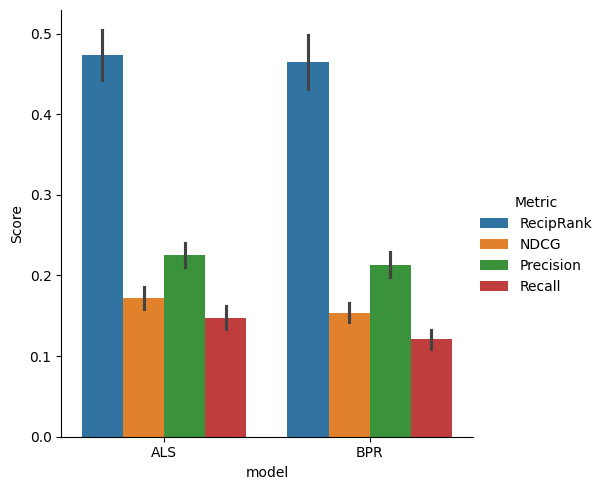

In [84]:
from lenskit.implicit import ALS, BPR

model_als = ALS()
pipe_als = topn_pipeline(model_als)

model_userknn = BPR()
pipe_userknn = topn_pipeline(model_userknn)

# Zbiór danych testowych będzie zorganizowany po użytkowniku (chcemy testować poprawność rekomendacji dla kazdego użytkownika)
all_test = ItemListCollection(UserIDKey)
# Rekomendacje będą generowane dla każdej pary model-użytkownik
all_recs = ItemListCollection(["model", "user_id"])

# Wykonujemy 5-krotną walidację skrośną
for split in crossfold_users(mlds, 15, SampleFrac(0.2)):
    # zapisujemy dane testowe
    all_test.add_from(split.test)

    # Klonujemy i trenujemy pipeline dla każdego splitu dla rozkładu macierzy
    fit_als = pipe_als.clone()
    fit_als.train(split.train)

    fit_userknn = pipe_userknn.clone()
    fit_userknn.train(split.train)

    # Generujemy i zapisujemy 10 rekomendacji
    als_recs = recommend(fit_als, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="ALS")

    userknn_recs = recommend(fit_userknn, split.test.keys(), 10)
    all_recs.add_from(userknn_recs, model="BPR")

ran = RunAnalysis()
ran.add_metric(RecipRank())
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())
results = ran.measure(all_recs, all_test)
# results.list_metrics().groupby("model").mean()
print(results.list_metrics().groupby("model").mean())
df = results.list_metrics().reset_index()
print(df.head())
print(df.columns)
df_melted = df.melt(id_vars="model", value_vars=["RecipRank", "NDCG", 'Precision', 'Recall'], 
                    var_name="Metric", value_name="Score")
print(df_melted.head())
print(df_melted.columns)
sns.catplot(data=df_melted, x="model", y="Score", hue="Metric", kind="bar")
plt.show()

> Miejsce na odpowiedź 2

## Zadanie 6. (2pkt)
1. Skorzystaj z algorytmów z pakietu *lenskit.basic* i porównaj działanie algorytmów Pop i Bias z wybranym przez siebie algorytmem z powyższych dla danych explicite.
2. Wygeneruj rekomendacje dla jednego wybranego przez siebie użytkownika ze zbioru testowego. Czy udało się trafić chociaż jeden item ze zbioru testowego?

       RecipRank      NDCG  Precision    Recall
model                                          
ALS     0.121942  0.025809   0.047049  0.019149
Bias    0.000234  0.000017   0.000164  0.000008
Pop     0.356283  0.097844   0.160000  0.070474
  model  user_id  RecipRank  NDCG  Precision  Recall
0  Bias      272        0.0   0.0        0.0     0.0
1  Bias        6        0.0   0.0        0.0     0.0
2  Bias      339        0.0   0.0        0.0     0.0
3  Bias      123        0.0   0.0        0.0     0.0
4  Bias       81        0.0   0.0        0.0     0.0
Index(['model', 'user_id', 'RecipRank', 'NDCG', 'Precision', 'Recall'], dtype='object')
  model     Metric  Score
0  Bias  RecipRank    0.0
1  Bias  RecipRank    0.0
2  Bias  RecipRank    0.0
3  Bias  RecipRank    0.0
4  Bias  RecipRank    0.0
Index(['model', 'Metric', 'Score'], dtype='object')


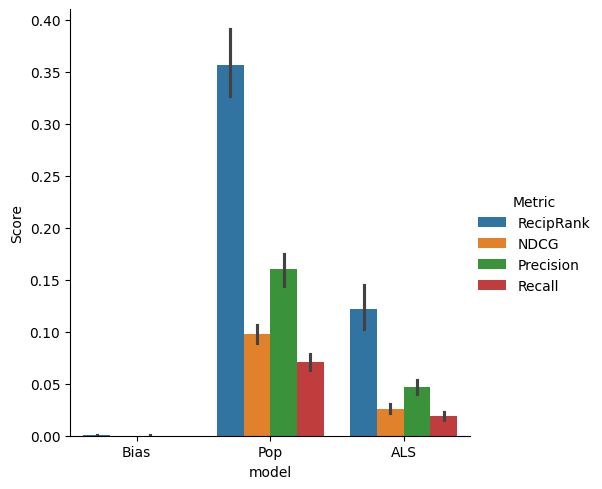

In [193]:
from lenskit.basic import BiasScorer, PopScorer


model_bias = BiasScorer()
pipe_bias = topn_pipeline(model_bias)

model_pop = PopScorer()
pipe_pop = topn_pipeline(model_pop)

model_userknn = BiasedMFScorer(features=50)
pipe_userknn = topn_pipeline(model_userknn)

# Zbiór danych testowych będzie zorganizowany po użytkowniku (chcemy testować poprawność rekomendacji dla kazdego użytkownika)
all_test = ItemListCollection(UserIDKey)
# Rekomendacje będą generowane dla każdej pary model-użytkownik
all_recs = ItemListCollection(["model", "user_id"])

# Wykonujemy 5-krotną walidację skrośną
for split in crossfold_users(mlds, 5, SampleFrac(0.2)):
    # zapisujemy dane testowe
    all_test.add_from(split.test)

    # Klonujemy i trenujemy pipeline dla każdego splitu dla rozkładu macierzy
    fit_bias = pipe_bias.clone()
    fit_bias.train(split.train)

    fit_pop = pipe_pop.clone()
    fit_pop.train(split.train)

    fit_userknn = pipe_userknn.clone()
    fit_userknn.train(split.train)

    # Generujemy i zapisujemy 10 rekomendacji
    als_recs = recommend(fit_bias, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="Bias")

    als_recs = recommend(fit_pop, split.test.keys(), 10)
    all_recs.add_from(als_recs, model="Pop")

    userknn_recs = recommend(fit_userknn, split.test.keys(), 10)
    all_recs.add_from(userknn_recs, model="ALS")

ran = RunAnalysis()
ran.add_metric(RecipRank())
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())
results = ran.measure(all_recs, all_test)
# results.list_metrics().groupby("model").mean()
print(results.list_metrics().groupby("model").mean())
df = results.list_metrics().reset_index()
print(df.head())
print(df.columns)
df_melted = df.melt(id_vars="model", value_vars=["RecipRank", "NDCG", 'Precision', 'Recall'], 
                    var_name="Metric", value_name="Score")
print(df_melted.head())
print(df_melted.columns)
sns.catplot(data=df_melted, x="model", y="Score", hue="Metric", kind="bar")
plt.show()

In [ ]:
import random


i = random.randint(0, len(all_test))

print(f"Wylosowany indeks: {i}, user: {all_test[i][0].user_id}")
bias_recs = recommend(fit_bias, [all_test[i][0].user_id], len(all_test[i][1]))
pop_recs = recommend(fit_pop, [all_test[i][0].user_id], len(all_test[i][1]))
als_recs = recommend(fit_userknn, [all_test[i][0].user_id], len(all_test[i][1]))
print(f"Ilosc rekomendacji: Bias {len(bias_recs[0][1])}, Pop {len(pop_recs[0][1])}, ALS {len(als_recs[0][1])}")

ran = RunAnalysis()
ran.add_metric(RecipRank())
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())

all_recs = ItemListCollection(["model", "user_id"])
all_recs.add_from(als_recs, model="ALS")
all_recs.add_from(bias_recs, model="Bias")
all_recs.add_from(pop_recs, model="Pop")

for idx in range(len(all_test[i][1])):
    original = all_test[i][1]
    bias = bias_recs[0][1]
    pop = pop_recs[0][1]
    als = als_recs[0][1]
    print(f"{original[idx].field('timestamp')} IDX:{idx}\nREAL:{original[idx].field('rating')}\nBIAS:{bias[idx].field('score')}\nPOP:{pop[idx].field('score')}\nALS:{als[idx].field('score')}")


Wylosowany indeks: 151, user: 312
Ilosc rekomendacji: Bias 45, Pop 45, ALS 45
['2003-01-21T19:25:08.000000000'] IDX:0
REAL:[4.]
BIAS:[5.158126]
POP:[0.9967068]
ALS:[4.74092]
['2003-01-21T19:25:24.000000000'] IDX:1
REAL:[4.]
BIAS:[5.158126]
POP:[0.99354863]
ALS:[4.709338]
['2003-01-21T19:07:18.000000000'] IDX:2
REAL:[4.]
BIAS:[5.158126]
POP:[0.9877206]
ALS:[4.6928244]
['2003-01-21T18:59:24.000000000'] IDX:3
REAL:[1.]
BIAS:[5.158126]
POP:[0.9733012]
ALS:[4.686061]
['2003-01-21T19:37:10.000000000'] IDX:4
REAL:[4.]
BIAS:[5.158126]
POP:[0.9711819]
ALS:[4.6792846]
['2003-01-21T19:31:57.000000000'] IDX:5
REAL:[4.]
BIAS:[5.158126]
POP:[0.9669433]
ALS:[4.673048]
['2003-01-21T19:28:43.000000000'] IDX:6
REAL:[5.]
BIAS:[5.158126]
POP:[0.9648968]
ALS:[4.6715136]
['2003-01-21T19:31:00.000000000'] IDX:7
REAL:[4.]
BIAS:[5.158126]
POP:[0.962871]
ALS:[4.66505]
['2003-01-21T19:09:51.000000000'] IDX:8
REAL:[3.]
BIAS:[5.158126]
POP:[0.9588402]
ALS:[4.62986]
['2003-01-21T19:24:40.000000000'] IDX:9
REAL:[5.]